In [15]:
import numpy as np
from pathlib import Path as P
import pickle
# from visualize_utils import make_vid
import cv2

    
result_path = P('/mnt/12T/DJ/PCDet_output/IA-SSD-GAN-vod-aug/debug/eval/checkpoint_epoch_11')
data_ids = np.loadtxt(str(result_path / 'frame_ids.txt'), delimiter=',', dtype=str)[:-1]

with open(str(result_path / 'gt.pkl'), 'rb') as f:
    gt = pickle.load(f)

# load det
with open(str(result_path / 'dt.pkl'), 'rb') as f:
    dt = pickle.load(f)

In [16]:
from vod.visualization.settings import label_color_palette_2d
from matplotlib.lines import Line2D

keys = list(gt.keys())
cls_name = ['Car','Pedestrian', 'Cyclist', 'Others']
color_dict = {}
for i, v in enumerate(cls_name):
    color_dict[v] = label_color_palette_2d[v]

In [17]:
import open3d as o3d
from scipy.spatial.transform import Rotation as R
def get_radar(fname):
    assert fname.exists()
    radar_point_cloud = np.fromfile(str(fname), dtype=np.float32).reshape(-1, 7)
    return radar_point_cloud

def get_lidar(fname):
    assert fname.exists()
    radar_point_cloud = np.fromfile(str(fname), dtype=np.float32).reshape(-1, 4)
    return radar_point_cloud

def pcd_formating(pcd):
    num_pts = pcd.shape[0]
    zeros_pad = np.zeros([num_pts, 1])
    final_pcd = np.concatenate((zeros_pad, pcd), axis=1)
    return final_pcd

def get_rotation(yaw):
    # x,y,_ = arr[:3]
    # yaw = np.arctan(y/x)
    angle = np.array([0, 0, yaw])
    r = R.from_euler('XYZ', angle)
    return r.as_matrix()

def get_bbx_param(obj_info):

    center = obj_info[:3]
    extent = obj_info[3:6] + np.array([0, 0, 10])
    angle = -obj_info[6]
    # center[-1] += 0.5 * extent[-1]

    rot_m = get_rotation(angle)

    obbx = o3d.geometry.OrientedBoundingBox(center.T, rot_m, extent.T)
    return obbx

In [18]:
from visualize_point_based import transform_anno, drawBEV

anno_type = 'gt'
idx = 1
is_radar = False
if anno_type == 'pred':
    anno = dt[str(idx).zfill(5)][0]
else:
    anno = gt[str(idx).zfill(5)]
loc = anno['location']
yaw = anno['rotation_y']
extent = anno['dimensions']

if is_radar:
    data_path = P('/mnt/sda1/hantao/CenterPoint-KITTI/data/vod_radar/training/velodyne')
    pc = get_radar(data_path / (str(idx).zfill(5) + '.bin'))
else:
    data_path = P('/mnt/sda1/hantao/CenterPoint-KITTI/data/vod_lidar/training/velodyne')
    pc = get_lidar(data_path / (str(idx).zfill(5) + '.bin'))
pc = pcd_formating(pc)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(pc[:,1:4])

for cur_label_idx in range(len(anno['name'])):
    x, y, z = transform_anno(loc[cur_label_idx], str(idx).zfill(5), is_radar=is_radar)
    dx, dy, dz = extent[cur_label_idx]
    rot_y = yaw[cur_label_idx]
    obj_info = np.array([x, y, z, dx, dy, dz, rot_y])
    box = get_bbx_param(obj_info)

    ctr_idx = box.get_point_indices_within_bounding_box(pcd.points)
    print(str(len(ctr_idx)) + ' ' +str(anno['name'][cur_label_idx]))

330 bicycle
178 Car
194 Pedestrian
160 Pedestrian
180 Pedestrian
8 ride_other
1420 truck
526 motor
164 Pedestrian
136 Pedestrian
72 Pedestrian
404 bicycle


In [26]:
dt['00000']

[{'name': array(['Car', 'Pedestrian', 'Cyclist', 'Pedestrian', 'Pedestrian'],
        dtype='<U10'),
  'truncated': array([0., 0., 0., 0., 0.]),
  'occluded': array([0., 0., 0., 0., 0.]),
  'alpha': array([-1.426386 , -2.1150143, -1.5861177,  1.0341378,  0.7228546],
        dtype=float32),
  'bbox': array([[ 775.1606 ,  764.7454 , 1187.456  , 1153.889  ],
         [1566.755  ,  808.74786, 1654.426  ,  970.4131 ],
         [1113.4292 ,  811.97534, 1170.9165 ,  961.7288 ],
         [1357.1963 ,  849.99994, 1400.5282 ,  934.6004 ],
         [ 242.72327,  831.3657 ,  358.9768 , 1031.3574 ]], dtype=float32),
  'dimensions': array([[4.3862367 , 1.4763596 , 1.8857459 ],
         [0.6089068 , 1.6565527 , 0.67265815],
         [2.027682  , 1.713487  , 0.755212  ],
         [0.64498514, 1.6680328 , 0.6600641 ],
         [0.71270514, 1.5751764 , 0.58190435]], dtype=float32),
  'location': array([[ 0.40008008,  2.6011803 ,  9.690868  ],
         [ 7.121181  ,  3.7162771 , 16.419397  ],
         [ 

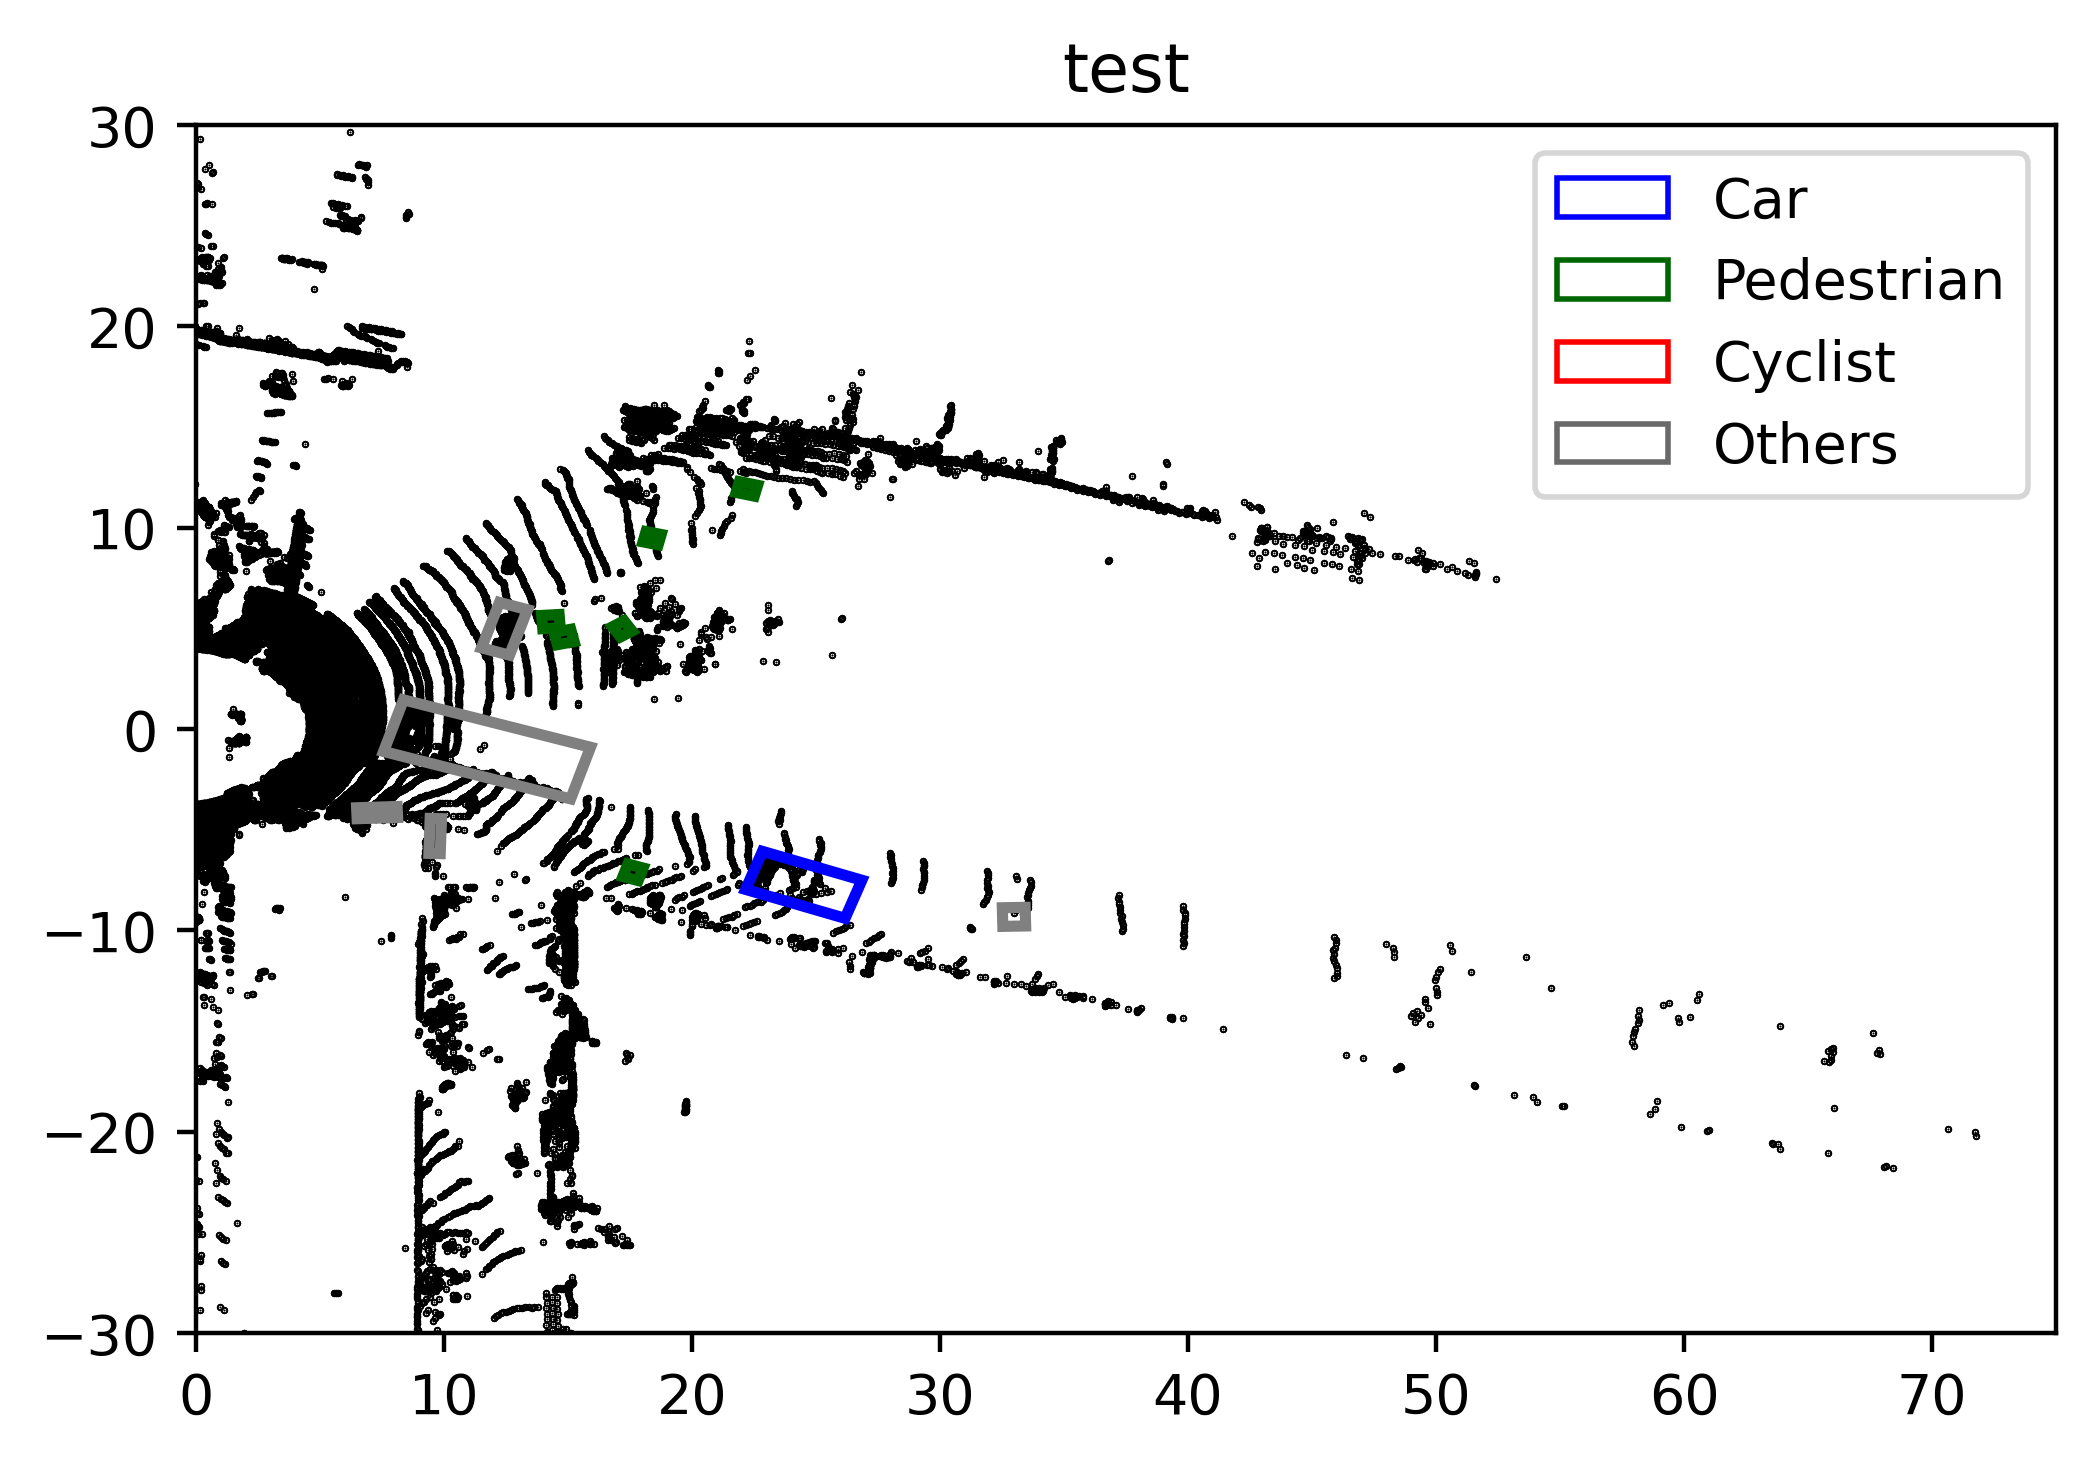

In [21]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 400
ax = plt.gca()
ax.set_xlim(-0, 75)
ax.set_ylim(-30, 30)
drawBEV(ax, pc, None, anno, color_dict, str(idx).zfill(5), 'test', is_radar=is_radar)